In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
# import utils
import pandas as pd

In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
def moving_average(a, n=1000):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Homopolymers

In [6]:
homo_dirs = ["/home/racoon/alena/homo/trunc_dna20t_phpc",
            "/home/racoon/alena/homo/trunc_dna20a_phpc",
             "/home/racoon/alena/homo/trunc_dna20c_phpc"]
homo_names = [dir_name.split("/")[-1] for dir_name in homo_dirs]
homo_labels = {name: name[9:12].upper() for name in homo_names}
homo_colors = {name: color for name, color in zip(homo_names, ["dodgerblue", "orange", "green"])}

## Plot SEM currents

In [7]:
def read_sem_from_dirs(dir_list, part_names):
    currents = []
    for dir_name in dir_list:
        cur_currents = []
        for fname in part_names:
            if os.path.isfile(os.path.join(dir_name, fname)):
                with open(os.path.join(dir_name, fname)) as cur_file:
                    current = np.array([float(x) for x in cur_file.readlines()])
                    cur_currents.append(current)
                    print(dir_name)
                    print(current.shape)
        currents.append(np.concatenate(cur_currents))
    return currents

In [10]:
part_names = ["sem_part01_10/current_joint.txt", "sem_part02_10/current_joint.txt", "sem_part03_10/current_joint.txt", "sem_part04_10/current_joint.txt", "sem_part05_10/current_joint.txt", "sem_part06_10/current_joint.txt", "sem_part07_10/current_joint.txt"]
homo_sem = read_sem_from_dirs(homo_dirs, part_names)

homo_sem[1] = - homo_sem[1]
homo_sem[2] = - homo_sem[2]


/home/racoon/alena/homo/trunc_dna20t_phpc
(178,)
/home/racoon/alena/homo/trunc_dna20t_phpc
(179,)
/home/racoon/alena/homo/trunc_dna20t_phpc
(130,)
/home/racoon/alena/homo/trunc_dna20t_phpc
(129,)
/home/racoon/alena/homo/trunc_dna20t_phpc
(129,)
/home/racoon/alena/homo/trunc_dna20t_phpc
(129,)
/home/racoon/alena/homo/trunc_dna20t_phpc
(129,)
/home/racoon/alena/homo/trunc_dna20a_phpc
(1001,)
/home/racoon/alena/homo/trunc_dna20a_phpc
(376,)
/home/racoon/alena/homo/trunc_dna20c_phpc
(1001,)
/home/racoon/alena/homo/trunc_dna20c_phpc
(378,)


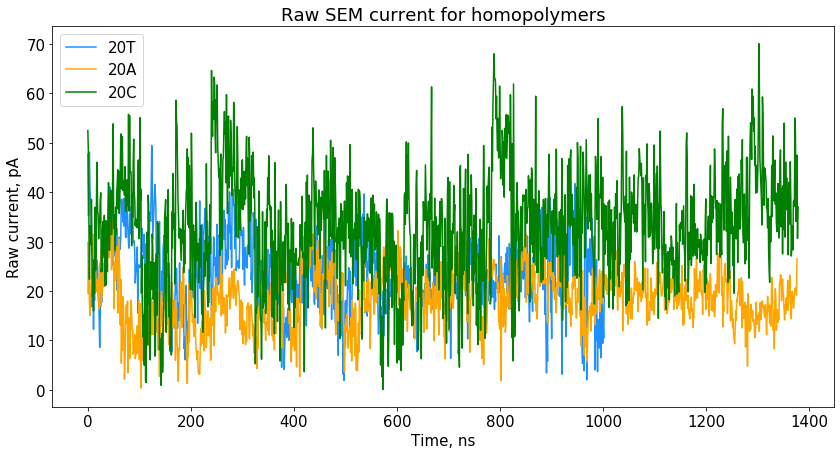

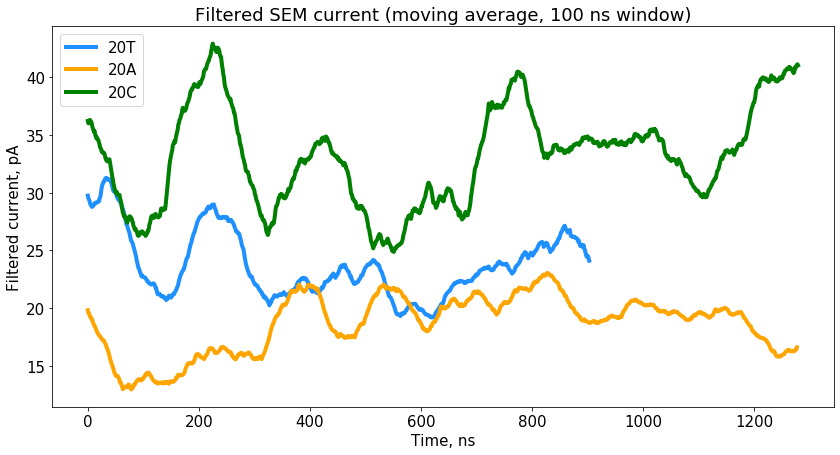

In [12]:
plt.figure(figsize=(14, 7))
for current, name in zip(homo_sem, homo_names):
    plt.plot(current, label=homo_labels[name], c=homo_colors[name])
    
plt.title("Raw SEM current for homopolymers")
plt.xlabel("Time, ns")
plt.ylabel("Raw current, pA")
plt.legend()
plt.savefig("plots/raw_sem_homo.svg")
plt.savefig("plots/raw_sem_homo.png", dpi=300)

plt.figure(figsize=(14, 7))
# for current, name in zip(homo_sem, homo_names):
#     plt.plot(current, alpha=0.2, c=homo_colors[name])
for current, name in zip(homo_sem, homo_names):
    plt.plot(moving_average(current, n=100), label=homo_labels[name], c=homo_colors[name], lw=4)
    
plt.title("Filtered SEM current (moving average, 100 ns window)")
plt.xlabel("Time, ns")
plt.ylabel("Filtered current, pA")
plt.legend()
plt.savefig("plots/filtered_sem_homo.svg")
plt.savefig("plots/filtered_sem_homo.png", dpi=300)

## Plot histogram and fit gaussian

In [15]:
def fit_gaussians(currents, start=200):
    params = [norm.fit(moving_average(current, n=100)[start:]) for current in currents]
    return params

In [16]:
homo_params = fit_gaussians(homo_sem)

## Scale to experimental data

In [17]:
experimental_mean = [13.5, 11.59, 17.085]
experimental_std = [0.46, 0.53, 1]

homo_mean = [i[0] for i in homo_params]
homo_std = [i[1] for i in homo_params]

In [39]:
homo_sem = [(sem + 0.6) / 1.85 for sem in homo_sem]

In [41]:
homo_params

[(12.893577800569801, 1.3076304557358274),
 (10.785051372202563, 1.0257275197053781),
 (18.35257199661211, 2.279555235417127)]

Fitted values
trunc_dna20t_phpc
Mean: 12.893577800569801
Std: 1.3076304557358274
trunc_dna20a_phpc
Mean: 10.785051372202563
Std: 1.0257275197053781
trunc_dna20c_phpc
Mean: 18.35257199661211
Std: 2.279555235417127


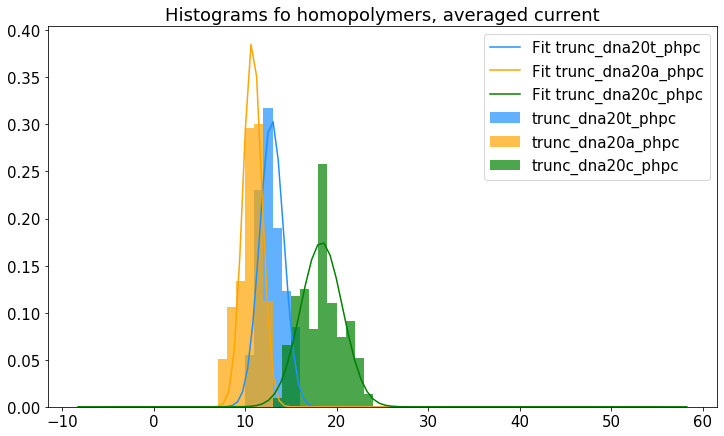

In [42]:
homo_params = fit_gaussians(homo_sem)

plt.figure(figsize=(12, 7))
print("Fitted values")
colors = ["dodgerblue", "orange", "green"]
for current, name, color, param in zip(homo_sem, homo_names, colors, homo_params):
    print(name)
    print("Mean: " + str(param[0]))
    print("Std: " + str(param[1]))
    plt.hist(moving_average(current, n=100)[100:], label=name, bins=50, range=(0, 50), alpha=0.7, density=True, color=color)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, param[0], param[1])
    plt.plot(x, y, label="Fit " + name, c=color)
    
plt.title("Histograms fo homopolymers, averaged current")
plt.legend()

## Plot experimental values against calculated

In [43]:
experimental_mean = [13.5, 11.59, 17.085]
experimental_std = [0.46, 0.53, 1]

homo_mean = [i[0] for i in homo_params]
homo_std = [i[1] for i in homo_params]

In [18]:
m, b = np.polyfit([0] + experimental_mean, [0] + homo_mean, 1)


In [19]:
plt.figure(figsize=(7, 7))
for exp, sem, exp_std, sem_std, name in zip(experimental_mean, homo_mean, experimental_std, homo_std, homo_names):
    plt.errorbar(exp, sem, xerr=exp_std, yerr=sem_std, c=homo_colors[name], label=homo_labels[name])
    plt.scatter(exp, sem, marker=".")

plt.plot(np.arange(5, 25), m*np.arange(5, 25) + b)
plt.xlabel("Experimental current, pA")
plt.ylabel("SEM current, pA")
plt.plot(range(5, 40), range(5, 40))
plt.legend()
plt.title("Comparison of experimental and SEM currents")
plt.savefig("plots/exp_sem_comparison.svg")
plt.savefig("plots/exp_sem_comparison.png", bbox_inches='tight')

In [21]:
homo_sem = [(curr + 0.6) / 1.85 for curr in homo_sem]

## Refit for scaled current

In [36]:
homo_params = fit_gaussians(homo_sem)

plt.figure(figsize=(12, 7))
print("Fitted values")
colors = ["dodgerblue", "orange", "green"]
for current, name, color, param in zip(homo_sem, homo_names, colors, homo_params):
    print(name)
    print("Mean: " + str(param[0]))
    print("Std: " + str(param[1]))
    plt.hist(moving_average(current, n=100)[200:], label=homo_labels[name], bins=50, range=(0, 50), alpha=0.5, density=True, color=color)
    xmin, xmax = plt.xlim()
    x = np.linspace(5, 25, 100)
    y = norm.pdf(x, param[0], param[1])
    plt.xlim(5, 25)
    plt.plot(x, y, label="Fit " + homo_labels[name], c=color, lw=4)
    
plt.title("Histograms fo homopolymers, averaged current")
plt.xlabel("Current, pA")

plt.legend()
plt.savefig("plots/sem_hist_scaled.svg")
plt.savefig("plots/sem_hist_scaled.png", dpi=300)

Fitted values
trunc_dna20t_phpc
Mean: 12.893577800569801
Std: 1.3076304557358274
trunc_dna20a_phpc
Mean: 10.785051372202563
Std: 1.0257275197053781
trunc_dna20c_phpc
Mean: 18.35257199661211
Std: 2.279555235417127


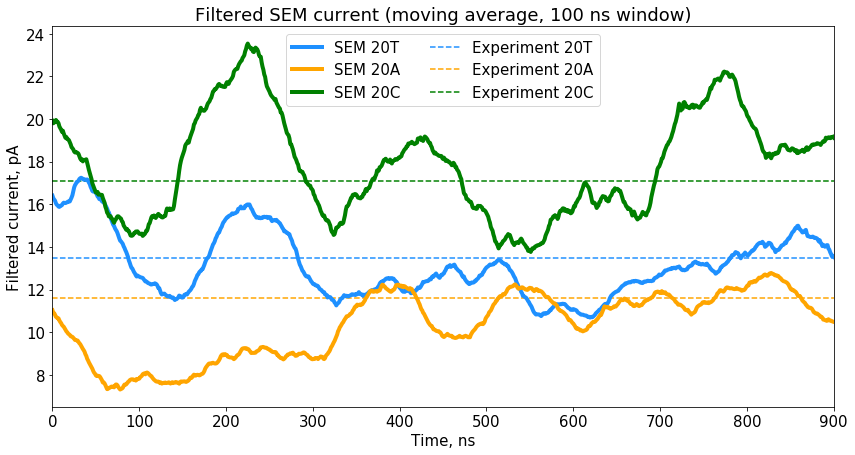

In [35]:
plt.figure(figsize=(14, 7))

for current, name, exp in zip(homo_sem, homo_names, experimental_mean):
    plt.plot(moving_average(current, n=100), label="SEM " + homo_labels[name], c=homo_colors[name], lw=4)
    plt.hlines(exp, 0, 900, color=homo_colors[name], linestyle="--", label="Experiment " + homo_labels[name])
plt.xlim(0, 900)
plt.title("Filtered SEM current (moving average, 100 ns window)")
plt.xlabel("Time, ns")
plt.ylabel("Filtered current, pA")
plt.legend(ncol=2)
plt.savefig("plots/filtered_sem_homo_scaled.svg")
plt.savefig("plots/filtered_sem_homo_scaled.png", dpi=300, layout="tight")